<a href="https://colab.research.google.com/github/yajuna/linearRegression/blob/master/regression_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This notebook details the comparision between decision tree regression, and the KNN regression of the tree trunk temperature modeling problem.

Assume $Y=f(\mathbf{X})+\epsilon$

Here $Y:$ response

(temperature in tree trunk)

$\mathbf{X}=[X_1, ..., X_n]:$ features, or predictors

(weather condition)

$\epsilon:$ random error term (independent of $\mathbf{X}$)

## Data explanation
We model the temperature of a tree trunk using various regression methods, based on weather conditions and measurements of the bark and core of the tree trunks.

We use data collected onsite in Brazil, over a 7 day period, in August of 2022. These data include weather data, as well as temperature data consisting of core and bark temperatures, with two mid-trunk temperatures as validation for our model.

We used a developed wireless sensor device that can measure temperature in 10 different position (direction and height) around the tree trunk and 3 different depths. Two spreadsheets were populated with 1 week long of data both from the tree and from our weather station in Brazil.

The Tree Data Spreadsheet has the following notation:

1. DXX@YY, where D = direction (N = North, S = South, E = East, W =West), XX = depth of the temperature sensor from the tree core, and YY = height of the temperature sensor. For example: S4.5cm@1m = sensor to the South 4.5 cm depth at 1 m height.
2. Only the external sensor has a different notation, namely W\_Ext\_Temp\@ 3.5m = to the West at 3.5 m height.

The weather station (Modelo D140193 of Ammonit Measurement GmbH) is located near the tree. The weather station Spreadsheet has the following parameters:

  1. ``Anemometer;win\_speed;Avg (m/s)'': Average wind speed in m/s measured by a anemometer
  2. ``Wind Vane TMR;wind\_direction;Avg ($^{\circ}$)'': Average wind direction in $^{\circ}$ measured by a Wind Vane
  3. ``Hygro/Thermo;humidity;Avg (\%)'': Average  humidity in \% measured by a Hygrometer
  4. ``Hygro/Thermo;temperature;Avg ($^{\circ}$C)'': Average temperature in $^{\circ}$C measured by a Hygrometer
  5. ``Barometer;air\_pressure;Avg (hPa)'': Average air pressure in hPa   measured by a Barometer
  6. ``DNI (Direct Normal Irradiance) Pyrheliometer;solar\_DNI;Avg (W/m$^2$)'':  Average Direct Normal Irradiance in W/m$^2$ measured by a Pyrheliometer.

The Direct Normal Irradiance (DNI) is a measurement of the Solar Irradiance. The Global Irradiance is the sum of the DNI and the Diffuse Irradiance. DNI is a fraction of the global solar irradiation, and is the most important parameter in a solar plant installation. So, we use of DNI to measure solar radiation in this model.

Weather data is collected every 10 minutes, starting at 00:00; temperature data is collected every 3 minutes, starting at 00:01. It is reasonable to assume weather parameters and tree temperatures are continuous functions of time, so we linearly interpret the collected data to obtain measurements of the same length for our regression analysis.

The radius of the mango tree is $r = 0.135$ m, and consider a 24 hour period. We use $n_t$ to denote time steps over time, and $n_x$ grid points in space, and these are parameters used in the linear interpolation of temperature and weather data.

In [76]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import sys
print("Python 3 version is", sys.version)
import matplotlib
print("Matplotlib version is", matplotlib.__version__)
print("Numpy version is", np.__version__)
print("Pandas version is", pd.__version__)

Python 3 version is 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Matplotlib version is 3.7.1
Numpy version is 1.25.2
Pandas version is 1.5.3


In [77]:
# from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error
# from sklearn import preprocessing
import sklearn
print("scikit learn version is", sklearn. __version__)

scikit learn version is 1.2.2


In [78]:
# define parameter
n_t = 450
radius = 0.135 # unit m
time = np.linspace(0, 24, n_t, endpoint = False)

In [79]:
def fetch_temp_for_date(data, date): # , num_points=412
    # Filter data for the given date
    date_filtered_data = data[data['datetime'].dt.date == date]

    # # If there are more data points than needed, truncate the DataFrame
    # if len(date_filtered_data) > num_points:
    #     date_filtered_data = date_filtered_data.iloc[:num_points]

    # Extract temperature data
    core_temp = date_filtered_data['s135_3'].to_numpy()
    mid_temp1 = date_filtered_data['w9_3'].to_numpy()
    mid_temp2 = date_filtered_data['n45_3'].to_numpy()
    bark_temp = date_filtered_data['w_ext_35'].to_numpy()

    return core_temp, mid_temp1, mid_temp2, bark_temp

In [80]:
def fetch_weather_for_date(data, date):
    # Filter data for the given date
    date_filtered_data = data[data['datetime'].dt.date == date]

    # # If there are more data points than needed, truncate the DataFrame
    # if len(date_filtered_data) > num_points:
    #     date_filtered_data = date_filtered_data.iloc[:num_points]

    # Extract temperature data
    wind_speed = date_filtered_data['wind_speed'].to_numpy()
    humidity = date_filtered_data['humidity'].to_numpy()
    air_temperature = date_filtered_data['air_temperature'].to_numpy()
    air_pressure = date_filtered_data['air_pressure'].to_numpy()
    solar_DNI = date_filtered_data['solar_DNI'].to_numpy()

    return wind_speed, humidity, air_temperature, air_pressure, solar_DNI

    ## To fix

In [81]:
# # for binder's jupyterlab
# !pip3 install openpyxl

In [82]:
colnames = ['datetime', 's45_1', 'e9_1', 'n135_1','e45_2', 'n9_2', 'w135_2', 'n45_3', 'w9_3','s135_3', 'w_ext_35']
url1 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Tree_Temp_Values_AUG21_to_AUG28_2022.xlsx"
dataTemp = pd.read_excel(url1,names=colnames)

# if use data locally:
# dataTemp = pandas.read_excel('Tree_Temp_Values_OCT21_to_OCT28_2022.xlsx', names=colnames)

# training data processing- measured temperature data from Brazil

# fetch and process data for August 21, 2022 for training
train_coreTemp, train_midTemp1, train_midTemp2, train_barkTemp = fetch_temp_for_date(dataTemp, pd.Timestamp('2022-08-21'))

# fetch and process data for August 22, 2022 for testing
test_coreTemp, test_midTemp1, test_midTemp2, test_barkTemp = fetch_temp_for_date(dataTemp, pd.Timestamp('2022-08-22'))

train_interp_temp_size = train_coreTemp.size
# linear interpolate the measured temperature
train_coreTemp = np. interp(time, np.linspace(0,24,train_interp_temp_size),train_coreTemp)
train_midTemp1 = np. interp(time, np.linspace(0,24,train_interp_temp_size),train_midTemp1)
train_midTemp2 = np. interp(time, np.linspace(0,24,train_interp_temp_size),train_midTemp2)
train_barkTemp = np. interp(time, np.linspace(0,24,train_interp_temp_size),train_barkTemp)

test_interp_temp_size = test_coreTemp.size
test_coreTemp = np. interp(time, np.linspace(0,24,test_interp_temp_size),test_coreTemp)
test_midTemp1 = np. interp(time, np.linspace(0,24,test_interp_temp_size),test_midTemp1)
test_midTemp2 = np. interp(time, np.linspace(0,24,test_interp_temp_size),test_midTemp2)
test_barkTemp = np. interp(time, np.linspace(0,24,test_interp_temp_size),test_barkTemp)

print("measured temperature data read")


<ipython-input-79-438d4642de18>:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  date_filtered_data = data[data['datetime'].dt.date == date]


measured temperature data read


In [83]:
### Read weather data

colnames = ['datetime', 'wind_speed', 'wind_direction', 'humidity', 'air_temperature', 'air_pressure', 'solar_DNI']
url2 = "https://raw.githubusercontent.com/yajuna/linearRegression/master/Weather_Station_AUG21_to_AUG28_2022.xlsx"
dataWeather = pd.read_excel(url2,names=colnames)

# if use locally:
# dataWeather = pandas.read_excel('Weather_Station_OCT21_to_OCT28_2022.xlsx', names = colnames)

# training data processing- measured temperature data from Brazil

#########################
# fetch and process data for August 21, 2022 for training
# train_windSpeed, train_humidity, train_airTemp, train_airPressure, train_solar = fetch_weather_for_date(dataWeather, pd.Timestamp('2022-08-21'))

# fetch and process data for August 21, 2022 for training
# test_windSpeed, test_humidity, test_airTemp, test_airPressure, test_solar = fetch_weather_for_date(dataWeather, pd.Timestamp('2022-08-22'))
########################


print("weather data read")

weather data read


In [84]:
date = '08-21'
## index counting and print to check
if date == '08-21':
# August 21:
    [begin, end] = [0, 144]
elif date == '08-22':
# August 22:
    [begin, end] = [144, 288]
elif date == '08-23':
# August 23:
    [begin, end] = [288, 432]
elif date == '08-24':
# August 24:
    [begin, end] = [432, 576]
elif date == '08-25':
# August 25:
    [begin, end] = [576, 720]
elif date == '08-26':
# August 26:
    [begin, end] = [720, 864]
elif date == '08-27':
# August 27:
    [begin, end] = [864, 1008]
elif date == '08-28':
# August 28:
    [begin, end] = [1008, 1152]

In [85]:
#### training from Aug 21:
date = '08-21'

train_windSpeed = np.array(dataWeather.wind_speed[begin:end])
train_humidity = np.array(dataWeather.humidity[begin:end])
train_airTemp = np.array(dataWeather.air_temperature[begin:end])+ 273.15
train_airPressure = np.array(dataWeather.air_pressure[begin:end])
train_solar = np.array(dataWeather.solar_DNI[begin:end])

train_interp_weather_size = train_solar.size

### linear interpret
train_airTemp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,train_interp_weather_size),train_airTemp)
train_windSpeed = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,train_interp_weather_size),train_windSpeed)
train_solar = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,train_interp_weather_size),train_solar)
train_humidity = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,train_interp_weather_size),train_humidity)
train_airPressure = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,train_interp_weather_size),train_airPressure)
#### testing from Aug 26
# date = '08-26'
#### testing from Aug 22
date = '08-22'

test_windSpeed = np.array(dataWeather.wind_speed[begin:end])
test_humidity = np.array(dataWeather.humidity[begin:end])
test_airTemp = np.array(dataWeather.air_temperature[begin:end])+ 273.15
test_airPressure = np.array(dataWeather.air_pressure[begin:end])
test_solar = np.array(dataWeather.solar_DNI[begin:end])

test_interp_weather_size = test_solar.size

test_airTemp = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,test_interp_weather_size),test_airTemp)
test_windSpeed = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,test_interp_weather_size),test_windSpeed)
test_solar = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,test_interp_weather_size),test_solar)
test_humidity = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,test_interp_weather_size),test_humidity)
test_airPressure = np.interp(np.linspace(0,24,n_t), np.linspace(0,24,test_interp_weather_size),test_airPressure)

## Prepare training and testing data

The training data is collected on August 21, and the testing data is collected on August 22, as well as August 26

In [86]:
#include depth as training variable
# n = 0 for 9cm; n = 1 for 4.5cm
n = 1
depth_list = [0.09/radius, 0.045/radius]

# training Y temp
Ytrain_list = [train_midTemp1, train_midTemp2]

Ytest_list = [test_midTemp1, test_midTemp2]

# depth for training is depth1 or depth2
depth = np.ones(train_coreTemp.shape) * depth_list[n]

# Training data in x; training data in y
Xtrain = [1./train_humidity, train_airTemp, train_windSpeed, train_solar, depth, train_coreTemp, train_barkTemp]

X_train = np.array(Xtrain).T
Y_train = Ytrain_list[n]

# testing data in x, testing data in y.
ic_test = np.ones(test_coreTemp.shape) * Ytest_list[n][0]
Xtest = [1./test_humidity, test_airTemp, test_windSpeed, test_solar, depth, test_coreTemp, test_barkTemp]
X_test = np.array(Xtest).T
Y_test = Ytest_list[n]

450
450
450
450
450
450
450


## In the following, we look at regression with the K nearest neighbors (KNN) as well as Decision trees.

Both methods are implemented in Python, with the `scikit learn` library.

## The following two cells are for decision tree regression

In [87]:
# Fit regression model with decision tree
dt_regressor = DecisionTreeRegressor(max_depth=4)
dt_regressor.fit(X_train, Y_train)

DecisionTreeRegressor(max_depth=4)

In [88]:
# Fit regression model with random forest
rf_regressor = RandomForestRegressor(n_estimators = 5, random_state = 0)
rf_regressor.fit(X_train, Y_train)

RandomForestRegressor(n_estimators=5, random_state=0)

In [89]:
# prediction with the above regression models

y_1 = dt_regressor.predict(X_test)
y_2 = rf_regressor.predict(X_test)

Absolute error is 2.742164705882349 , Relative error is 0.10088906202657648


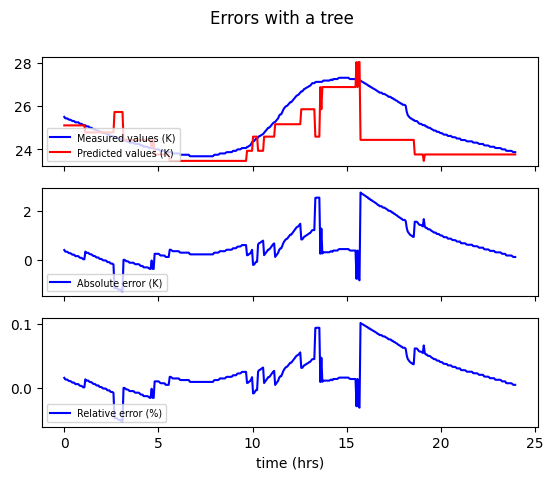

In [90]:
# visualization
print ("Absolute error is", np.max(np.abs(Y_test - y_1)), ", Relative error is", np.max(np.abs((Y_test - y_1)/Y_test)))


fig0, axs = plt.subplots(3, sharex=True, sharey=False)
fig0.suptitle('Errors with a tree')
axs[0].plot(time, Y_test, 'b-', label='Measured values (K)')
axs[0].plot(time, y_1, 'r-', label='Predicted values (K)')
axs[1].plot(time, Y_test - y_1, 'b-', label='Absolute error (K)')
axs[2].plot(time, (Y_test - y_1)/Y_test, 'b-', label='Relative error (%)')
axs[0].legend(loc='lower left', fontsize = 'x-small')
axs[1].legend(loc='lower left', fontsize = 'x-small')
axs[2].legend(loc='lower left', fontsize = 'x-small')
plt.xlabel('time (hrs)', fontsize=10)
# fig0.savefig("shallow_decisionTree.eps")
plt.show()

Absolute error is 2.1672800000000016 , Relative error is 0.07991445427728619


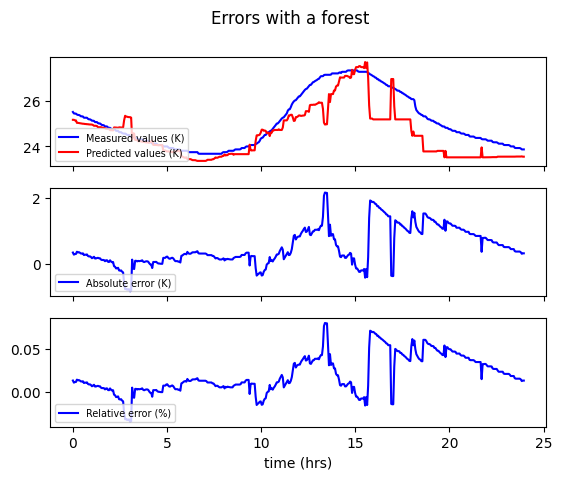

In [91]:
# visualization
print ("Absolute error is", np.max(np.abs(Y_test - y_2)), ", Relative error is", np.max(np.abs((Y_test - y_2)/Y_test)))


fig, axs = plt.subplots(3, sharex=True, sharey=False)
fig.suptitle('Errors with a forest')
axs[0].plot(time, Y_test, 'b-', label='Measured values (K)')

axs[0].plot(time, y_2, 'r-', label='Predicted values (K)')
axs[1].plot(time, Y_test - y_2, 'b-', label='Absolute error (K)')
axs[2].plot(time, (Y_test - y_2)/Y_test, 'b-', label='Relative error (%)')
axs[0].legend(loc='lower left', fontsize = 'x-small')
axs[1].legend(loc='lower left', fontsize = 'x-small')
axs[2].legend(loc='lower left', fontsize = 'x-small')
plt.xlabel('time (hrs)', fontsize=10)
# fig.savefig("deep_decisionTree.eps")
plt.show()

## In the following, we look at KNN regression model
We experiment with different values of $K$ and observe bias, as well as vriance.


In [92]:
n_neighbors = 4
# weights = "uniform", "distance"

knn = KNeighborsRegressor(n_neighbors, weights="distance")
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)

Absolute error is 2.774919889054818 , Relative error is 0.11486229465153228


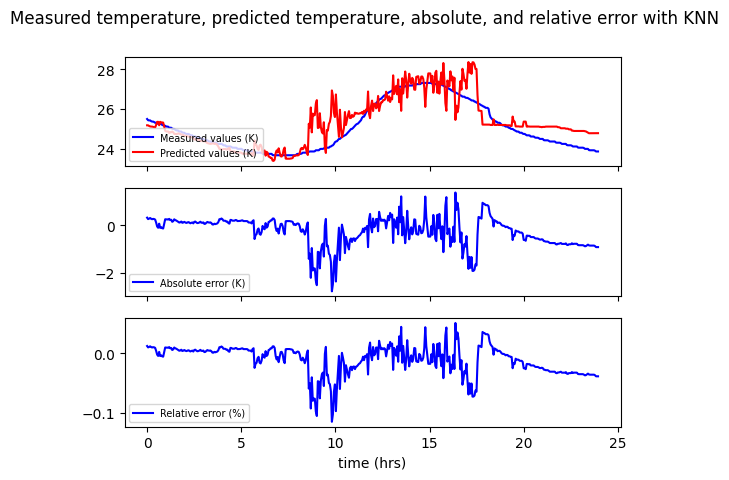

In [93]:
# visualization
print ("Absolute error is", np.max(np.abs(Y_test - Y_pred)), ", Relative error is", np.max(np.abs((Y_test - Y_pred)/Y_test)))

fig1, axs = plt.subplots(3, sharex=True, sharey=False)
fig1.suptitle('Measured temperature, predicted temperature, absolute, and relative error with KNN')
axs[0].plot(time, Y_test, 'b-', label='Measured values (K)')
axs[0].plot(time, Y_pred, 'r-', label='Predicted values (K)')
axs[1].plot(time, Y_test - Y_pred, 'b-', label='Absolute error (K)')
axs[2].plot(time, (Y_test - Y_pred)/Y_test, 'b-', label='Relative error (%)')

axs[0].legend(loc='lower left', fontsize = 'x-small')
axs[1].legend(loc='lower left', fontsize = 'x-small')
axs[2].legend(loc='lower left', fontsize = 'x-small')
plt.xlabel('time (hrs)', fontsize=10)
# fig.savefig("deep_decisionTree.eps")
plt.show()